# Diagramas de Ojo e Interferencia entre Símbolos

### Alumno: Saillen, S

## Consigna:

A partir del código proporcionado en esta Notebook y la dirección ip del SDR asignado, resolver las siguientes consignas.

1. Partiendo de la configuración por defecto (loopback digital) y para un $\beta$ del filtro coseno realzado igual a 1, 0.75, 0.5 y 0.25: 
   - ¿Como impacta el valor de $\beta$  en la respuesta al impulso del filtro?
   -  ¿Como impacta el valor de $\beta$ en la respuesta en frecuencia del filtro? y ¿Cuando el sistema es más inmune a un posible ruido gaussiano blanco?
   - Para los distintos valores de $\beta$ ¿Se observa ISI en el diagrama de ojo para el instante de muestreo ideal? Justifique su respuesta.
   - Analizando el diagrama de ojo para valores de $\beta$ cada vez mas pequeños ¿el sistema se vuelve más o menos sensible a un error en la fase del sincronismo? Justifique su respuesta.
2. Partiendo de la configuración por defecto (loopback digital) y para un $\beta = 0$ ¿Que es posible deducir del diagrama de ojo? y ¿Que filtro queda conformado para este valor de $\beta$?
3. Para una $\beta = 0.25$ y para cantidades de taps del filtro de $12 T_{symb}$, $8 T_{symb}$, $6 T_{symb}$ y $4 T_{symb}$ ¿Se produce algún tipo de pérdida de desempeño en el sistema? ¿A qué es debido? 
4. Configurando el sistema con un loopback desactivado (la señal sale e ingresa por antena) y un $\beta = 1$ ¿que conclusiones puede obtener al comparar este diagrama de ojo con el observando para el caso de loopback digital? Tenga en cuenta que posiblemente deba realizar varios intentos hasta obtener un diagrama de ojo adecuado. 
5. Una forma de reducir la relación señal a ruido (SNR) en la entrada del receptor es dismimuyendo la potencia de la señal de salida del transmisor, esto es haciendo cada vez más negativo el valor de "TxAtten". ¿Que conclusiones puede obtener de la observación del diagrama de ojo a medida que disminuye esta SNR con el sistema configurado con loopback en RF?
6. Diseñe un código que reemplace el armado del diagrama de ojo realizado por la función "dc.eye_plot".

## Desarrollo:

### Configuración Previa

#### Installs

In [8]:
# !pip install pyadi-iio
# !pip install scikit-dsp-comm
# !pip install scikit-commpy

#### Imports

In [1]:
import adi
import numpy as np
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
import matplotlib.pyplot as plt

#### Configuracion del SDR

In [30]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.34"  # RELLENAR CON LA IP DEL SDR ASIGNADO
SamplingRate     = 4e6                # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 2                  # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 954e6              # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -60                # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 4e6                # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq           # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack"      # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0                  # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw             # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20-1

#### Función Filtro Raiz Coseno Realzado

In [31]:
#-------------------- Root Raised Cosine Filter Function --------------------

def rrcosdesign(beta,span,sps):
    index     = np.arange(-(span*sps)/2,(span*sps)/2+1,1)
    Ts        = sps
    rrcFilter = np.array([])

    for n in index:
        if beta == 0:
            aux       = np.sinc(n/Ts)/np.sqrt(Ts)
            rrcFilter = np.append(rrcFilter,aux)
        else:
            if n == Ts/(4*beta) or n == -Ts/(4*beta):
                aux       = beta*((np.pi+2)*np.sin(np.pi/(4*beta))+(np.pi-2)*np.cos(np.pi/(4*beta)))/(np.pi*np.sqrt(2*Ts))
                rrcFilter = np.append(rrcFilter,aux)
            else:
                a         = np.cos((1+beta)*np.pi*n/Ts)
                b         = (1-beta)*np.pi*np.sinc((1-beta)*n/Ts)/(4*beta)
                c         = 4*beta/(np.pi*np.sqrt(Ts))
                aux       = c*(a+b)/(1-(4*beta*n/Ts)**2)
                rrcFilter = np.append(rrcFilter,aux)
    return rrcFilter

#### Parametros de Transmisión

In [32]:
#------------------ Transmitter configuration parameters ------------------ 

num_bits    = 2**13   # Number of transmitted bits
sps         = 8       # Samples per symbol
span        = 12       # The filter is truncated to span symbols
beta        = 1    # Excess-bandwidth parameter

#### Respuesta al Impulso del Filtro Raiz Coseno Realzado

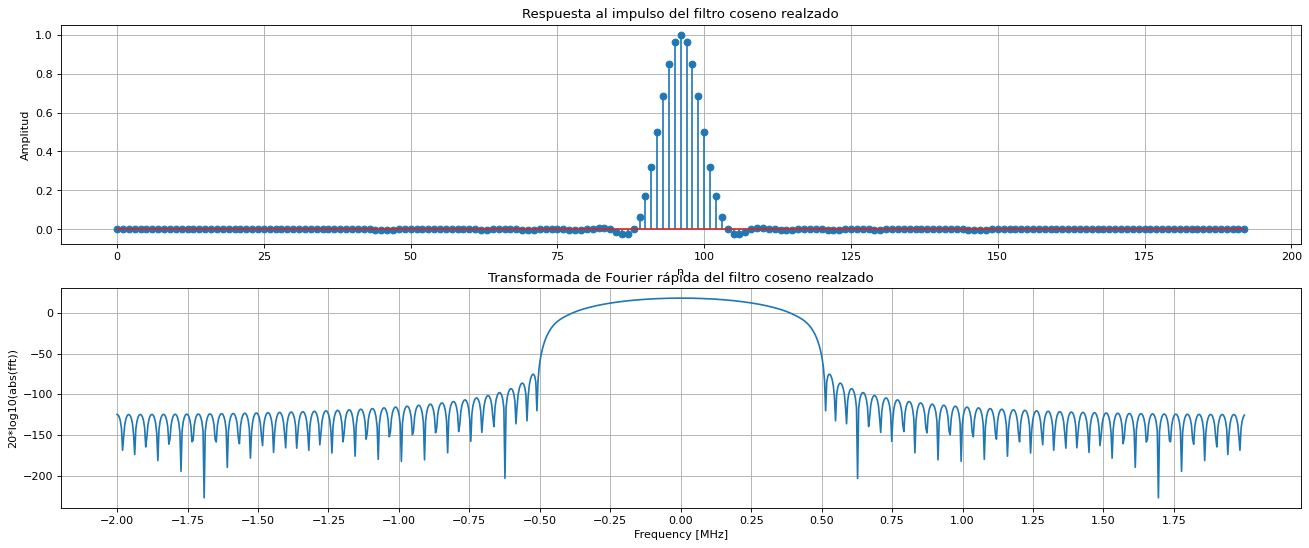

In [33]:
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()

# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

#### Asignaciones de los Parámetros al SDR

In [34]:
#------------------------------- SDR Setup ------------------------------- 

sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten 
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize

#### Generador de Simbolos

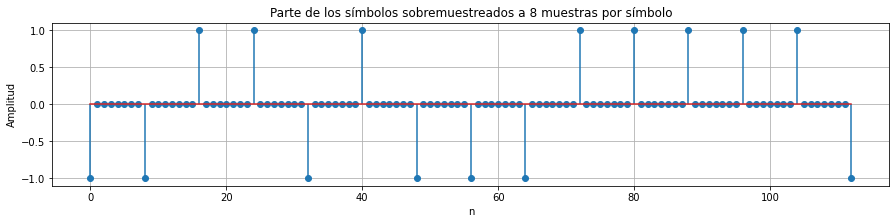

In [35]:
#------------------------------- Symbol Generator ------------------------------- 

bits       = np.random.randint(0, 2, num_bits)
symbolsUps = np.array([])

for bit in bits:
    pulse      = np.zeros(sps)
    pulse[0]   = bit*2-1 
    symbolsUps = np.concatenate((symbolsUps, pulse)) 
    
plt.figure(figsize=(15,3))
plt.stem(symbolsUps[0:113])
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title("Parte de los símbolos sobremuestreados a %i muestras por símbolo" %sps)
plt.grid()
plt.show()

#### Componente I de la señal Transmitida

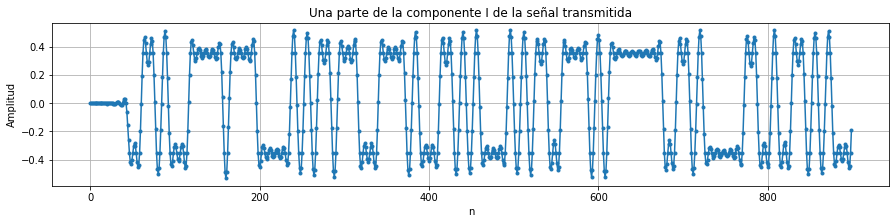

In [36]:
#------------------------------- Transmitted I component ------------------------------- 
txSignal = np.convolve(symbolsUps, rrcFilter)
plt.figure(figsize=(15,3))
plt.plot(txSignal[0:900], '.-')
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Una parte de la componente I de la señal transmitida')

plt.grid()
plt.show()

#### Transmisión

In [37]:
#------------------------------- Transmitter ------------------------------- 

sdr.tx(txSignal*2**14)

#### Recepción

In [38]:
#------------------------------- Receiver ------------------------------- 

rxSignal = sdr.rx()/2**14

#### Componente I de la señal Recibida

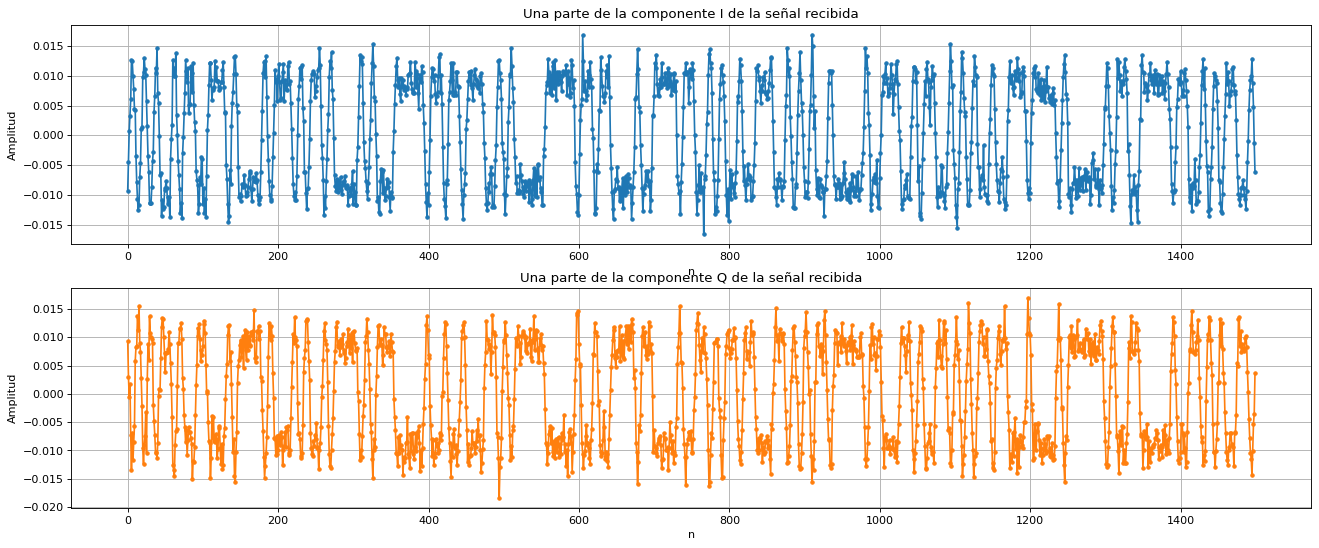

In [39]:
#------------------------------- Received I component ------------------------------- 
# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(np.real(rxSignal[0:1500]), '.-')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title('Una parte de la componente I de la señal recibida')
plt.grid()

#------------------------------- Received Q component -------------------------------
# Plot time domain
plt.subplot(2,1,2)
plt.plot(np.imag(rxSignal[0:1500]), '.-C1')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title('Una parte de la componente Q de la señal recibida')
plt.grid()
plt.show()

#### Componente I/Q Filtrado + Diagrama de Ojo

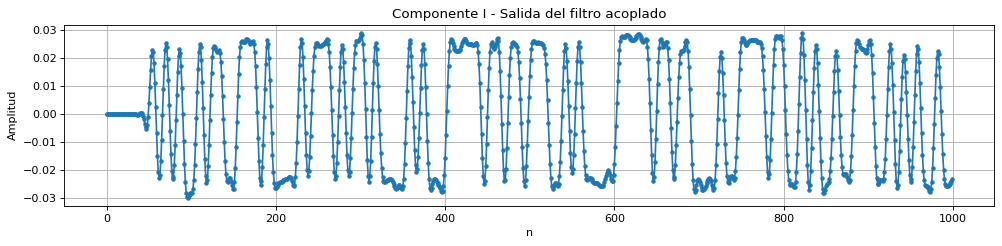

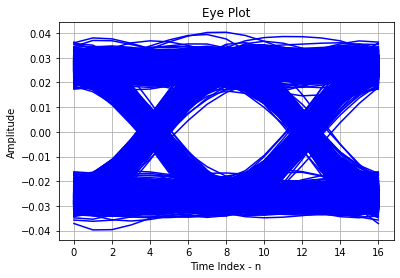

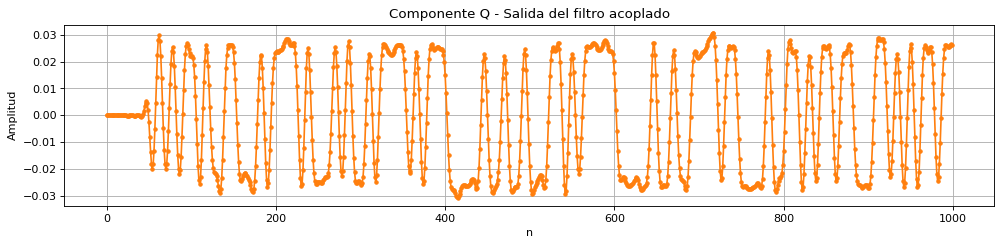

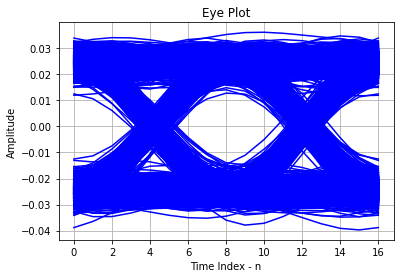

In [40]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

#### Pseudo-Apagado del Transmisor

In [47]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0  = -70
sdr.rx_lo                  = int(2400e6)
sdr.tx(np.zeros(1024))

#### Borrado del Objeto SDR

In [48]:
# Destroy radio object
del(sdr)

### 1. Partiendo de la configuración por defecto (loopback digital) y para un $\beta$ del filtro coseno realzado igual a 1, 0.75, 0.5 y 0.25:

- ¿Como impacta el valor de $\beta$  en la respuesta al impulso del filtro?
- ¿Como impacta el valor de $\beta$ en la respuesta en frecuencia del filtro? y ¿Cuando el sistema es más inmune a un posible ruido gaussiano blanco?
- Para los distintos valores de $\beta$ ¿Se observa ISI en el diagrama de ojo para el instante de muestreo ideal? Justifique su respuesta.
- Analizando el diagrama de ojo para valores de $\beta$ cada vez mas pequeños ¿el sistema se vuelve más o menos sensible a un error en la fase del sincronismo? Justifique su respuesta.

**Respuesta A:**

Al reducir el valor de beta (correspondiente al roll-off the la función Raiz Coseno Realzado) la función tiende a ser mas ancha, decae mas lentamente y tiende a oscilar mas.

**Respuesta B:**

El filtro responde directamente proporcional al valor de $\beta$, al reducir el beta tambien se reduce el ancho de banda del filtro.

El sistema es más inmune a un posible ruido gaussiano blanco al tener mas ancho de banda, por ende a mayor $\beta$.

**Respuesta C:**

Ningun valor de beta parecería presentar ISI, los valores mas bajos pueden llegar a tener muy poco, pero siempre atraviesan los valores de -1 y 1 sin dispersion aparente.

**Respuesta D:**

A menores valores de beta el sistema se vuelve mas sensible a un error en la fase de tiempo (jitter), debido a que a menores valores de beta la pendiente interna es menor.

### 2. Partiendo de la configuración por defecto (loopback digital) y para un $\beta = 0$ ¿Que es posible deducir del diagrama de ojo? y ¿Que filtro queda conformado para este valor de $\beta$?

**Respuesta:** Para un $\beta=0$ podemos deducir mediante el diagrama de ojo que la función presenta un alto nivel de ISI, tiene mucha sensibilidad a errores en la fase del tiempo y poca inmunidad hacia los mismos. Para un valor de $\beta = 0$ queda conformado un filtro Raiz Seno Realzado.

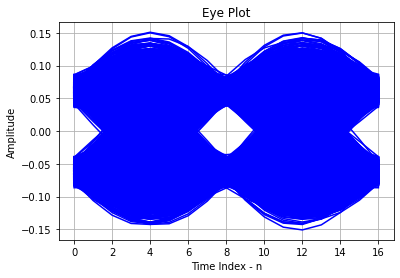

### 3. Para una $\beta = 0.25$ y para cantidades de taps del filtro de $12 T_{symb}$, $8 T_{symb}$, $6 T_{symb}$ y $4 T_{symb}$ ¿Se produce algún tipo de pérdida de desempeño en el sistema? ¿A qué es debido? 

(Supuse que los taps corresponden al valor de *span* "The filter is truncated to span symbols"), al reducir la cantidad de taps del filtro se puede producr una perdida del desempeño del filtro, permitiendo que mayores frecuencias a las deseadas puedan pasar, tambien se puede observar un aumento en el ISI.

### 4. Configurando el sistema con un loopback desactivado (la señal sale e ingresa por antena) y un $\beta = 1$ ¿que conclusiones puede obtener al comparar este diagrama de ojo con el observando para el caso de loopback digital? Tenga en cuenta que posiblemente deba realizar varios intentos hasta obtener un diagrama de ojo adecuado. 

**Respuesta:** Luego de varios intentos pude conseguir el Diagrama de Ojo que mejor se veia. A simple vista lo mas notable es el aumento del ISI, luego tambien se puede observar la disminución de la amplitud de la señal (los valores no estan pasando por $+-1$ sino que pasan por valores mucho mas pequeños (hay una atenuación de señal)

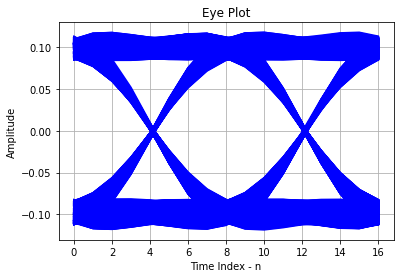

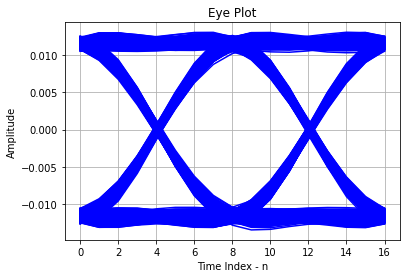

### 5. Una forma de reducir la relación señal a ruido (SNR) en la entrada del receptor es dismimuyendo la potencia de la señal de salida del transmisor, esto es haciendo cada vez más negativo el valor de "TxAtten". ¿Que conclusiones puede obtener de la observación del diagrama de ojo a medida que disminuye esta SNR con el sistema configurado con loopback en RF?  

A medida que disminuyo el valor de "TxAtten" el diagrama de ojo se vuelve cada vez mas difuso, contenindo cada vez mas ISI.

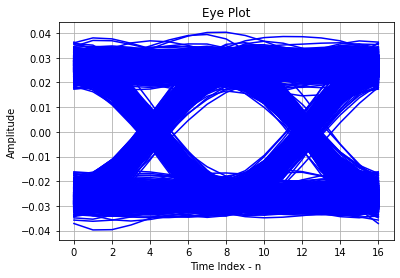

### 6. Diseñe un código que reemplace el armado del diagrama de ojo realizado por la función "dc.eye_plot".

In [43]:
def eyePlot(signal, l, s=0, title = 'Eye Plot'):
    plt.figure(figsize=(6,4))
    a = np.arange(0, l + 1)
    plt.plot(a, signal[s:s + l + 1], 'r')
    i_max = int((len(signal) - s) / l) - 1
    for i in range(1,i_max):
        plt.plot(a, signal[s + i * l:s + l + 1 + i * l], 'b')
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Eye Plot')
    return 0

0

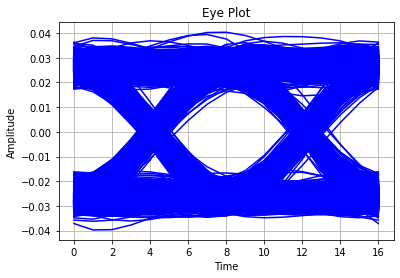

In [44]:
eyePlot(i_Signal, L)